<img src="./img/HWNI_logo.svg"/>

# Lab 10 - Model Accuracy and Reliability

In [1]:
%matplotlib notebook

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import scipy.stats

# choose colors that work for most color-blind folks
sns.set_palette("colorblind")
sns.set(color_codes=True)

import util.lab09utils as utils

from ipywidgets import interact,interactive, fixed, interact_manual

utils.formatDataframes()

## Model Accuracy

We'd like to know how good our model is. Squared error says something, but it's not in sensible units. We could try to use bootstrapping or parametric methods to establish how much error we believe we're making in each parameter, but then we couldn't compare across models.

R^2 to the rescue? Issue: the R^2 on the sample is a biased estimator of the R^2 on the population. Worse, the bias is stronger the more parameters we have, and the bias makes us think we're doing a good job!

Discuss biased and unbiased estimators here.

In [2]:
def ordinaryLeastSquares(regressors,targets):
    arrays = [regressors,targets]
    
    arrays = [np.expand_dims(array,0) if array.ndim == 1  
              else array 
              for array in arrays]

    regressors,targets = arrays

    regressorOuterProductInverse = np.linalg.inv(np.dot(regressors,regressors.T))
    weights = np.dot(np.dot(targets,regressors.T),regressorOuterProductInverse)
    return weights

In [3]:
def SS(xs):
    return np.sum(np.square(xs))

def leaveOutFrom(xs,index):
    return np.hstack([xs[:,:index],xs[:,index+1:]])

def leaveOneOutCV(xs,ys):
    N = xs.shape[1]; ws = np.zeros_like(xs); 
    denominator = SS(ys-np.mean(ys))
    for idx in range(N):
        ws[:,idx] = ordinaryLeastSquares(leaveOutFrom(xs,idx),
                                            leaveOutFrom(ys,idx))
    predictions = [np.dot(ws.T[idx],xs.T[idx]) for idx in range(N)]
    R_squared = 1 - SS(ys-predictions)/SS(ys-np.mean(ys))
    
    return R_squared

def computeR_squared(xs,ys,w):
    residuals = ys-np.dot(w.T,xs)
    R_squared = 1 - SS(residuals)/SS(ys-np.mean(ys))
    return R_squared

In [409]:
def runSimulation(trueDegree,populationSize=1000,sampleSize=10,
                 minDegree=0,maxDegree=10,numExperiments=25,xLimits=[-1.5,1.5]):
    
    weights = [0.5,1,-1.75,0.7,-0.65,0.6,0.55,0.5,0.45,0.4,0.35]
    weights = np.atleast_2d(weights[:trueDegree+1]).T
    
    plt.figure()
    plotModel(weights,limits=xLimits,label='True Model')
    
    baseXs = np.random.uniform(*xLimits,size=populationSize)
    #baseXs = np.random.standard_normal(size=populationSize)*0.25

    xPopulation = np.asarray([np.ones(populationSize),baseXs])
    
    for degree in range(2,trueDegree+1):
        xPopulation = np.vstack([xPopulation,np.power(xPopulation[None,1,:],degree)])
    
    noise_level = 0.75
    #noise_level = 0.25
    yPopulation = np.dot(weights.T,xPopulation)+np.random.standard_normal(populationSize)*noise_level    
    
    R_squared_CV = np.zeros((maxDegree+1-minDegree,numExperiments))
    R_squared_fitted = np.zeros((maxDegree+1-minDegree,numExperiments))
    R_squared_actual = np.zeros((maxDegree+1-minDegree,numExperiments))
    
    
    plt.scatter(baseXs.T,yPopulation.T,alpha=0.1,s=72)
    
    for experiment in range(numExperiments):
        modelXs = xPopulation[None,0,:]

        indices = np.random.choice(populationSize,size=sampleSize)

        ySample = yPopulation[:,indices]
        
        if experiment == 0:
            plt.scatter(np.squeeze(xPopulation[1,indices]),
                    np.squeeze(ySample),
                     alpha=1,s=48,color='k',zorder=20)
    
        for degree in range(minDegree,maxDegree+1):
            if degree > 0:
                modelXs = np.vstack([modelXs,np.power(xPopulation[None,1,:],degree)])

            degreeIndex = degree-minDegree
            xSample = modelXs[:,indices]

            R_squared_CV[degreeIndex,experiment] = leaveOneOutCV(xSample,ySample)

            w_fitted = ordinaryLeastSquares(xSample,ySample).T
            
            if experiment == 0:
                
                if degree in [0,1,2,3,8,trueDegree,maxDegree]:                        
                    plotModel(w_fitted,limits=xLimits)

            R_squared_fitted[degreeIndex,experiment] = computeR_squared(xSample,ySample,w_fitted)
            R_squared_actual[degreeIndex,experiment] = computeR_squared(modelXs,yPopulation,w_fitted)
    
    plt.ylim([-10,10])
    plt.legend(loc='best')
    R_squared_actual = np.mean(R_squared_actual,axis=1)
    R_squared_CV = np.mean(R_squared_CV,axis=1)
    R_squared_fitted = np.mean(R_squared_fitted,axis=1)
    
    if maxDegree >= 8:
        for idx in range(-1,maxDegree-10):
            if R_squared_fitted[idx] < 0.8:
                R_squared_fitted[idx] = 1
    
    return R_squared_fitted,R_squared_actual,R_squared_CV

def plotModel(weights,label=None,limits=[-2,2]):
    N = 1000
    xs = np.linspace(*limits,num=N)
    inputXs = np.asarray([np.ones(N)])
    for degree in range(1,weights.shape[0]):
        inputXs =  np.vstack([inputXs,np.power(xs,degree)])
        
    if label == None:
        degree = weights.shape[0]-1
        label = str(degree)
        width = 2
        zorder = 15-degree
    else:
        width = 6
        zorder= 1
    outputs = np.dot(weights.T,inputXs)
    plt.plot(xs,np.squeeze(outputs),
             linewidth=width,label=label,zorder=zorder)

def plotResults(fitted,actual,cross_validated,minDegree=0,maxDegree=10):
    degrees = range(minDegree,maxDegree+1)
    
    plt.figure()
    for label,r_squared_estimate in zip(['data','actual','CV'],
                                  [fitted,actual,cross_validated]):
        plot_R_squared(degrees,r_squared_estimate,label)
    
    current_ymin = plt.gca().get_ylim()[0]
    plt.xlim(-0.5,maxDegree+0.5)
    plt.ylim(max(-0.2,current_ymin),1.1)
    
    plotAxes()
    
    plt.ylabel('R**2');plt.xlabel('Modeling Polynomial Degree')
    plt.legend(loc='best');
    
def plot_R_squared(degrees,values,label):
    plt.plot(degrees,values,
         linestyle='-',linewidth=6,
         marker='.',markersize=36,label=label)

def plotAxes():
    xLim = plt.xlim()
    yLim = plt.ylim()
    plt.hlines([0,0],0,xLim[1],color='k',linewidth=4); 
    plt.vlines([0,0],0,yLim[1],color='k',linewidth=4) 

<IPython.core.display.Javascript object>


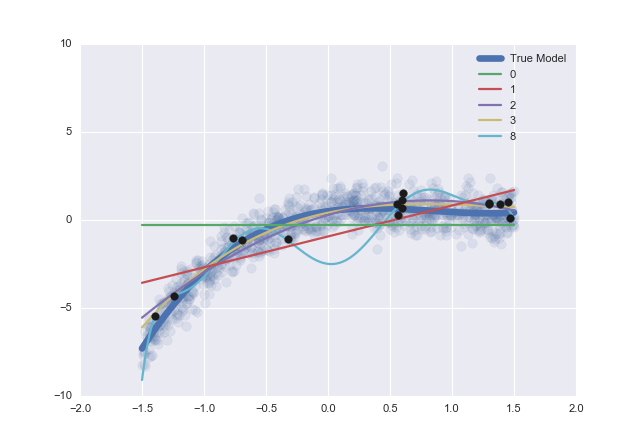

<IPython.core.display.Javascript object>


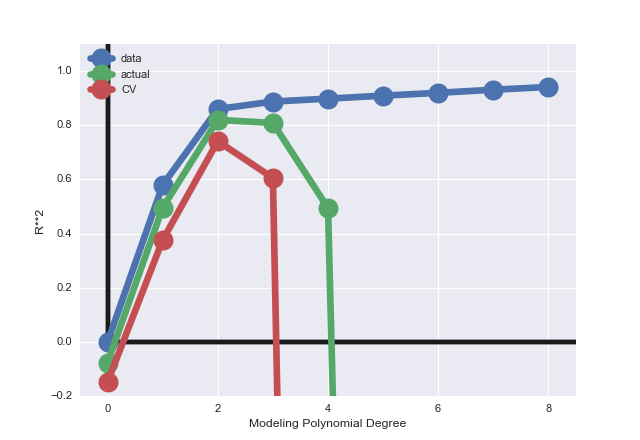

In [411]:
minDegree = 0
trueDegree = 3
maxDegree = 8

fitted,actual,cross_validated = runSimulation(trueDegree,minDegree=minDegree,
                                              maxDegree=maxDegree,sampleSize=15,
                                             numExperiments=250,)

plotResults(fitted,actual,cross_validated,minDegree=minDegree,maxDegree=maxDegree)

Write a < b < c for the R^2 values obtained directly from the data, via cross-validation, and on the entire population. Why is this the case?

Why can the R^2 be less than 0? Why is the actual and cross-validated R^2 generally less than 0 for the degree-0 polynomial model?

Why does the fitted R^2 get closer to 1 as the degree goes up? Consider the example run. What do these models look like?

The y-axes are clipped so that negative values less than -0.2 are not plotted. Why are the cross-validation-obtained and actual values of R^2 so negative for the high degree polynomial models?

For `trueDegree = 3`:

Does cross-validation R^2 always peak at the true degree? If it does, then why is this the case?

What does it mean for the actual R^2 to not have its peak value at the true degree?

Increase the sample size by an order of magnitude. What happens to the R^2 curves?

## Model Reliability

Bootstrapping: use the empirical distribution as an estimate of the true distribution, instead of using the empirical mean/empirical standard deviation as estimates of true mean/true standard deviation. Sample from this estimate to approximate sampling from the population. Profit?

In [338]:
def clean_lmplot():
    ax = plt.gca()
    ax.set_ylim(-15,15)

def plotTrueModel(w,b):
    ax = plt.gca()
    xLims = ax.get_xlim()
    mesh = np.linspace(*xLims)
    plt.plot(mesh,w*mesh+b,
             color='k',linewidth=4,
             label='True Model')
    plt.legend(loc='best')

def setupLinearModel(N,gaussianNoise=True,slope=2,offset=0):

    noise_level = 2

    xs = np.random.normal(size=N)*3

    if gaussianNoise:
        noise = np.random.standard_normal(size=N)*noise_level
    else:
        noise = np.random.standard_cauchy(size=N)
    
    ys = slope*xs + offset + noise 
    df = pd.DataFrame.from_dict({'x':xs,'y':ys})
    
    return df

<IPython.core.display.Javascript object>


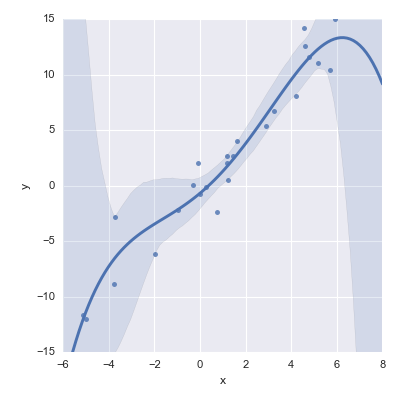

In [300]:
N = 25
gaussianNoise = True
w = 2; b = 0

df = setupLinearModel(N,gaussianNoise=True,
                     slope=w,offset=b)

sns.lmplot(data=df,x='x',y='y',order=5,ci=95);
clean_lmplot()

## robust regression

# sns.lmplot(data=df,x='x',y='y',robust=False,ci=95);
# clean_lmplot()

Compare linear regression to increasing orders of polynomial regression.

Increase N to 500, and do the above again. What happens to reliability? Compare the area where data is dense to area where data is sparse. Connection to *generalization*.

Go back to linear fits. Change `gaussianNoise` to `False`. What happens to reliability? 

Increase N. Is there still an issue? Run multiple times. Is your answer different on different runs? Why is this?

Robust regression tries to get around the problem of outliers. Compare robust regression on N=10 and N=50 to linear regression on the same.

## Accuracy Meets Reliability

<IPython.core.display.Javascript object>


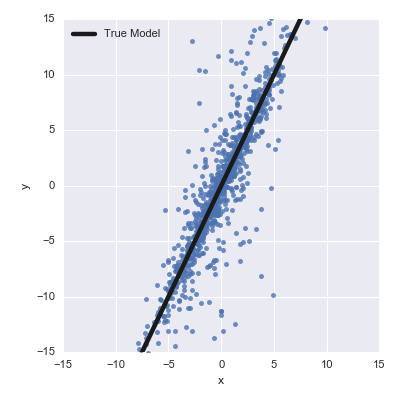

In [407]:
N = 1000
gaussianNoise = False
w = 2; b = 0

df = setupLinearModel(N,gaussianNoise=gaussianNoise)

sns.lmplot(data=df,x='x',y='y',robust=True,ci=95);
clean_lmplot()
plotTrueModel(w,b)

## robust regression

# sns.lmplot(data=df,x='x',y='y',robust=False,ci=95);
# clean_lmplot()
# plotTrueModel(w,b)

How do we measure accuracy here?

How accurate and reliable are polynomial models in regions where the data is dense? What about outside of this region? Increase N to 100. Does this change your answer?

Again compare linear and increasing orders of polynomial regression, but now with N = 100 and non-Gaussian noise. Which models better handle the presence of outliers?

Increase N to 1000. Have the issues with outliers gone away? Compare higher-order polynomial and linear regression.

Combine non-Gaussian noise with robust regression. What happens?

Robust regression is "strangely unpopular" in the eyes of many statisticians. Based on your experiences above, can you explain both why it should be used and why people don't use it much?